https://github.com/Project-MONAI/tutorials/blob/main/3d_segmentation/brats_segmentation_3d.ipynb

In [1]:
import os
import shutil
import tempfile
import time
import matplotlib.pyplot as plt
from monai.apps import DecathlonDataset
from monai.config import print_config
from monai.data import DataLoader, decollate_batch
from monai.handlers.utils import from_engine
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric
from monai.networks.nets import SegResNet
from monai.transforms import (
    Activations,
    Activationsd,
    AsDiscrete,
    AsDiscreted,
    Compose,
    Invertd,
    LoadImaged,
    MapTransform,
    NormalizeIntensityd,
    Orientationd,
    RandFlipd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    RandSpatialCropd,
    Spacingd,
    EnsureTyped,
    EnsureChannelFirstd,
)
from monai.utils import set_determinism
import onnxruntime
from tqdm import tqdm

import torch

print_config()
set_determinism(seed=0)

2025-11-12 14:10:53.341670928 [W:onnxruntime:Default, device_discovery.cc:164 DiscoverDevicesForPlatform] GPU device discovery failed: device_discovery.cc:89 ReadFileContents Failed to open file: "/sys/class/drm/card0/device/vendor"


MONAI version: 1.6.dev2542
Numpy version: 2.1.2
Pytorch version: 2.8.0+cu126
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 612f3dd3cba4d73cfcea4b5329079e20aa31523d
MONAI __file__: /home/<username>/miniconda3/envs/m_quant_py310/lib/python3.10/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: 5.4.4
Nibabel version: 5.3.2
scikit-image version: 0.25.2
scipy version: 1.15.3
Pillow version: 11.0.0
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.23.0+cu126
tqdm version: 4.67.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 7.0.0
pandas version: 2.3.2
einops version: 0.8.1
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For d

In [2]:
directory = "./seg_ckpts"
if directory is not None:
    os.makedirs(directory, exist_ok=True)
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

./seg_ckpts


In [3]:
# Corrected conversion for FeTS labels
class ConvertToMultiChannelBasedOnBratsClassesd(MapTransform):
    """
    FeTS/BraTS label mapping (ints on disk): 0=background, 1=NCR/NET, 2=edema, 4=enhancing (ET)
    Build 3-channel multi-label [TC, WT, ET]:
      TC = (label==1) OR (label==4)
      WT = (label==1) OR (label==2) OR (label==4)
      ET = (label==4)
    """
    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            lab = d[key]
            tc = torch.logical_or(lab == 1, lab == 4)
            wt = torch.logical_or(torch.logical_or(lab == 1, lab == 2), lab == 4)
            et = (lab == 4)
            d[key] = torch.stack([tc, wt, et], dim=0).float()
        return d


# Transforms/Preprocessing taken as is from MONAI

In [4]:
# class ConvertToMultiChannelBasedOnBratsClassesd(MapTransform):
#     """
#     Convert labels to multi channels based on brats classes:
#     label 1 is the peritumoral edema
#     label 2 is the GD-enhancing tumor
#     label 3 is the necrotic and non-enhancing tumor core
#     The possible classes are TC (Tumor core), WT (Whole tumor)
#     and ET (Enhancing tumor).

#     """

#     def __call__(self, data):
#         d = dict(data)
#         for key in self.keys:
#             result = []
#             # merge label 2 and label 3 to construct TC
#             result.append(torch.logical_or(d[key] == 2, d[key] == 3))
#             # merge labels 1, 2 and 3 to construct WT
#             result.append(torch.logical_or(torch.logical_or(d[key] == 2, d[key] == 3), d[key] == 1))
#             # label 2 is ET
#             result.append(d[key] == 2)
#             d[key] = torch.stack(result, axis=0).float()
#         return d

train_transform = Compose(
    [
        # load 4 Nifti images and stack them together
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys="image"),
        EnsureTyped(keys=["image", "label"]),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.0, 1.0, 1.0),
            mode=("bilinear", "nearest"),
        ),
        RandSpatialCropd(keys=["image", "label"], roi_size=[224, 224, 144], random_size=False),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=1),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=2),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        RandScaleIntensityd(keys="image", factors=0.1, prob=1.0),
        RandShiftIntensityd(keys="image", offsets=0.1, prob=1.0),
    ]
)
val_transform = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys="image"),
        EnsureTyped(keys=["image", "label"]),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.0, 1.0, 1.0),
            mode=("bilinear", "nearest"),
        ),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
    ]
)

monai.transforms.spatial.dictionary Orientationd.__init__:labels: Current default value of argument `labels=(('L', 'R'), ('P', 'A'), ('I', 'S'))` was changed in version None from `labels=(('L', 'R'), ('P', 'A'), ('I', 'S'))` to `labels=None`. Default value changed to None meaning that the transform now uses the 'space' of a meta-tensor, if applicable, to determine appropriate axis labels.


# Load the data in a federated manner ready for the Data Valuation pipeline

In [5]:
# MINE!!

import os, copy, time, random, torch, numpy as np                                 
import glob
from tqdm import tqdm
import pandas as pd
from torch.utils.data import DataLoader
from monai.data import CacheDataset
import glob, nibabel as nib, pandas as pd
from monai.data import CacheDataset, DataLoader
from monai.transforms import (
    LoadImaged, EnsureChannelFirstd, Orientationd, ScaleIntensityd,
    RandFlipd, RandSpatialCropd, Compose, SelectItemsd
)

from utils import *
  
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# -----------------------------------------------------------
# 0. paths & meta-data (unchanged) ---------------------------
# -----------------------------------------------------------
BRATS_DIR = "/mnt/d/Datasets/FETS_data/MICCAI_FeTS2022_TrainingData"
CSV_PATH  = f"{BRATS_DIR}/partitioning_1.csv"
MODALITIES = ["flair", "t1", "t1ce", "t2"]
LABEL_KEY  = "seg"

# -----------------------------------------------------------
# 1. read partition file  ➜  { id : [subjects] } ------------
# -----------------------------------------------------------
part_df       = pd.read_csv(CSV_PATH)
partition_map = (
    part_df.groupby("Partition_ID")["Subject_ID"]
           .apply(list).to_dict()
)                               # keys are 1 … 23

VAL_CENTRES = {16, 17, 18, 19, 20, 21, 22, 23}          # ← our hold-out set
# VAL_CENTRES = {22, 23}          # ← our sanity set

# split once, reuse everywhere
train_partitions = {cid: sids for cid, sids in partition_map.items()
                    if cid not in VAL_CENTRES}
val_subjects     = sum((partition_map[cid] for cid in VAL_CENTRES), [])

# -----------------------------------------------------------
# 2. helper to build MONAI-style record dicts ----------------
# -----------------------------------------------------------

def build_records(subject_ids):
    recs = []
    for sid in subject_ids:
        sdir = f"{BRATS_DIR}/{sid}"
        images = [f"{sdir}/{sid}_{m}.nii.gz" for m in MODALITIES]  # 4 modalities
        recs.append({"image": images, "label": f"{sdir}/{sid}_{LABEL_KEY}.nii.gz"})
    return recs


# -----------------------------------------------------------
# 3. MONAI CacheDatasets ------------------------------------
# -----------------------------------------------------------
# ── client-wise training sets ───────────────────────────────
CUT_OFF, FRAC, SEED = 16, 1.0, 42
rng = random.Random(SEED)

train_datasets = {}
for cid, subj_ids in train_partitions.items():
    if cid > CUT_OFF:                                    # keep your cap
        break
    k = max(1, int(len(subj_ids) * FRAC))                # e.g. 30 %
    sample_ids = rng.sample(subj_ids, k)
    train_datasets[cid] = CacheDataset(
        build_records(sample_ids), transform=train_transform, cache_rate=1
    )

# ── single validation dataset made from *all* val subjects ─
val_dataset = CacheDataset(
    build_records(val_subjects), transform=val_transform, cache_rate=1
)

print("train per-centre sizes:", {k: len(v) for k, v in train_datasets.items()})
print("validation size:", len(val_dataset))


Loading dataset: 100%|████████████████████████████████████████████████████████████████| 505/505 [19:08<00:00,  2.27s/it]

train per-centre sizes: {1: 511, 2: 6, 3: 15, 4: 47, 5: 22, 6: 34, 7: 12, 8: 8, 9: 4, 10: 8, 11: 14, 12: 11, 13: 35, 14: 6, 15: 13}
validation size: 505


In [6]:
# ── Check raw label integer values for a handful of validation cases ──
import os, random, nibabel as nib, numpy as np

raw_label_paths = []
for rec in val_dataset.data:  # CacheDataset stores the *pre-transform* dicts here
    lp = rec["label"]
    # If some pipelines wrap labels in a list, normalize to string:
    if isinstance(lp, (list, tuple)): lp = lp[0]
    raw_label_paths.append(str(lp))

random.shuffle(raw_label_paths)
check_n = min(10, len(raw_label_paths))
print(f"Checking raw label uniques for {check_n} validation cases...\n")
global_counts = {}

for i, p in enumerate(raw_label_paths[:check_n], 1):
    arr = nib.load(p).get_fdata().astype(np.int16)
    u = np.unique(arr)
    print(f"{i:02d}. {os.path.basename(p)} -> uniques: {u.tolist()}")
    # tally voxels per ID
    for v in u:
        global_counts[v] = global_counts.get(v, 0) + int((arr == v).sum())

print("\nGlobal voxel counts across inspected cases:")
for k in sorted(global_counts):
    print(f"  label {k}: {global_counts[k]}")


Checking raw label uniques for 10 validation cases...

01. FeTS2022_00782_seg.nii.gz -> uniques: [0, 1, 2, 4]
02. FeTS2022_00469_seg.nii.gz -> uniques: [0, 1, 2, 4]
03. FeTS2022_00557_seg.nii.gz -> uniques: [0, 1, 2, 4]
04. FeTS2022_00714_seg.nii.gz -> uniques: [0, 1, 2, 4]
05. FeTS2022_00444_seg.nii.gz -> uniques: [0, 1, 2, 4]
06. FeTS2022_00580_seg.nii.gz -> uniques: [0, 1, 2, 4]
07. FeTS2022_01583_seg.nii.gz -> uniques: [0, 1, 2, 4]
08. FeTS2022_00729_seg.nii.gz -> uniques: [0, 1, 2, 4]
09. FeTS2022_00768_seg.nii.gz -> uniques: [0, 1, 2, 4]
10. FeTS2022_00622_seg.nii.gz -> uniques: [0, 1, 2, 4]

Global voxel counts across inspected cases:
  label 0: 88487703
  label 1: 99519
  label 2: 524546
  label 4: 168232


In [7]:
# Presence/voxel count report over the *transformed* val set
import torch, os, pandas as pd
from torch.utils.data import DataLoader

def presence_report(dataset, batch_size=1, max_cases=None):
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
    rows, n_seen = [], 0
    with torch.no_grad():
        for batch in loader:
            y = batch["label"]                  # [B,3,D,H,W] from the *converter*
            ids = batch.get("label_meta_dict", {}).get("filename_or_obj", [f"case_{n_seen+i}" for i in range(y.shape[0])])
            for b in range(y.shape[0]):
                m = y[b]
                vox_tc = int(m[0].sum().item())
                vox_wt = int(m[1].sum().item())
                vox_et = int(m[2].sum().item())
                rows.append({
                    "case": os.path.basename(str(ids[b])),
                    "vox_TC": vox_tc, "vox_WT": vox_wt, "vox_ET": vox_et,
                    "has_TC": int(vox_tc > 0), "has_WT": int(vox_wt > 0), "has_ET": int(vox_et > 0),
                })
                n_seen += 1
                if max_cases and n_seen >= max_cases:
                    break
            if max_cases and n_seen >= max_cases:
                break
    df = pd.DataFrame(rows)
    total = len(df)
    sTC, sWT, sET = df["has_TC"].sum(), df["has_WT"].sum(), df["has_ET"].sum()
    print(f"Total cases scanned: {total}")
    print(f"Cases with TC: {sTC} ({100*sTC/total:.1f}%)")
    print(f"Cases with WT: {sWT} ({100*sWT/total:.1f}%)")
    print(f"Cases with ET: {sET} ({100*sET/total:.1f}%)")
    print("\nExamples with ET absent:")
    print(df.loc[df["has_ET"]==0, ["case","vox_TC","vox_WT","vox_ET"]].head(10).to_string(index=False))
    return df

df_presence = presence_report(val_dataset, batch_size=1)


Total cases scanned: 505
Cases with TC: 501 (99.2%)
Cases with WT: 505 (100.0%)
Cases with ET: 501 (99.2%)

Examples with ET absent:
    case  vox_TC  vox_WT  vox_ET
 case_45       0    7089       0
 case_64       0   18958       0
case_101       0   33560       0
case_165       0   66343       0


Case 1 | sagittal x=72 (0..154) | plane voxels: TC=827, WT=1172, ET=460, TC_only=367, ET_only=0


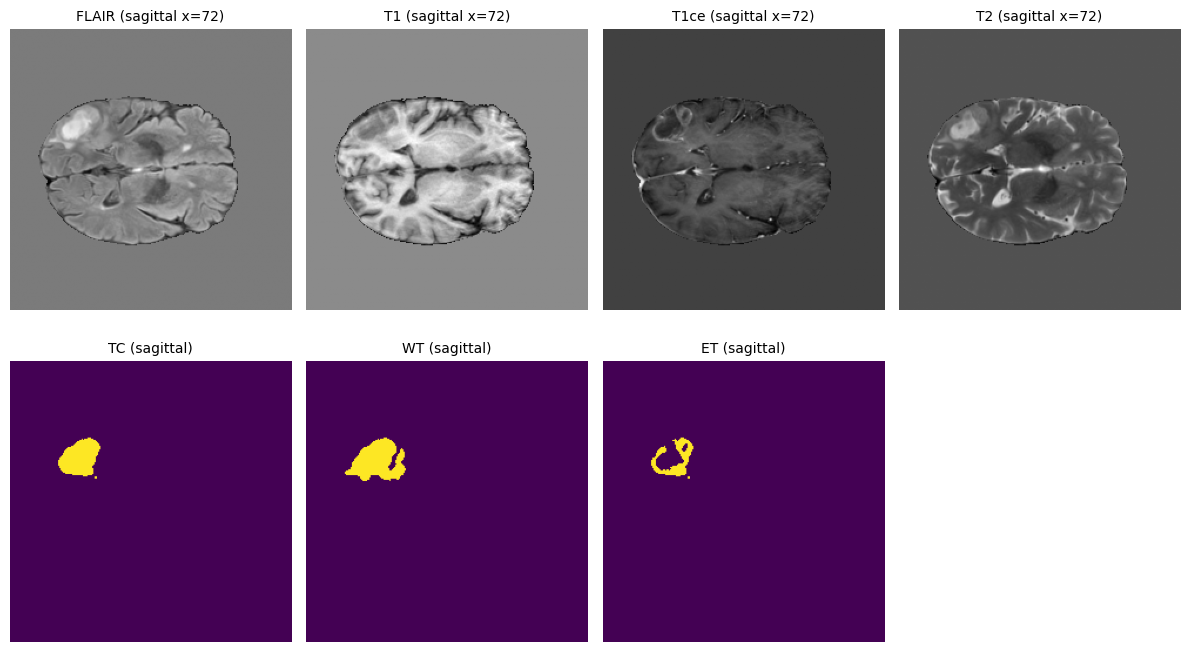

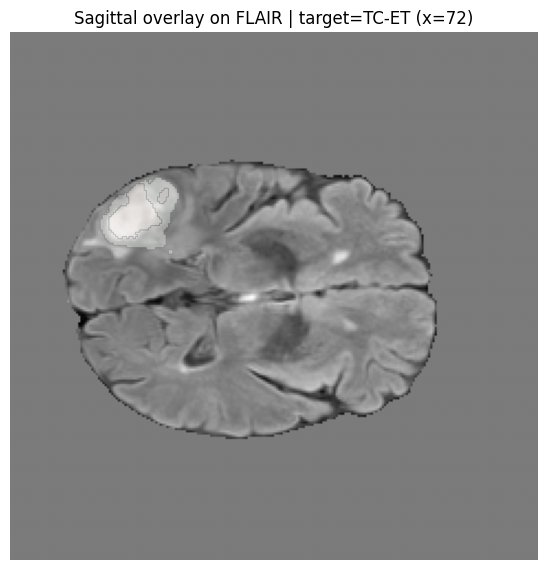

Case 2 | sagittal x=93 (0..154) | plane voxels: TC=645, WT=1667, ET=280, TC_only=365, ET_only=0


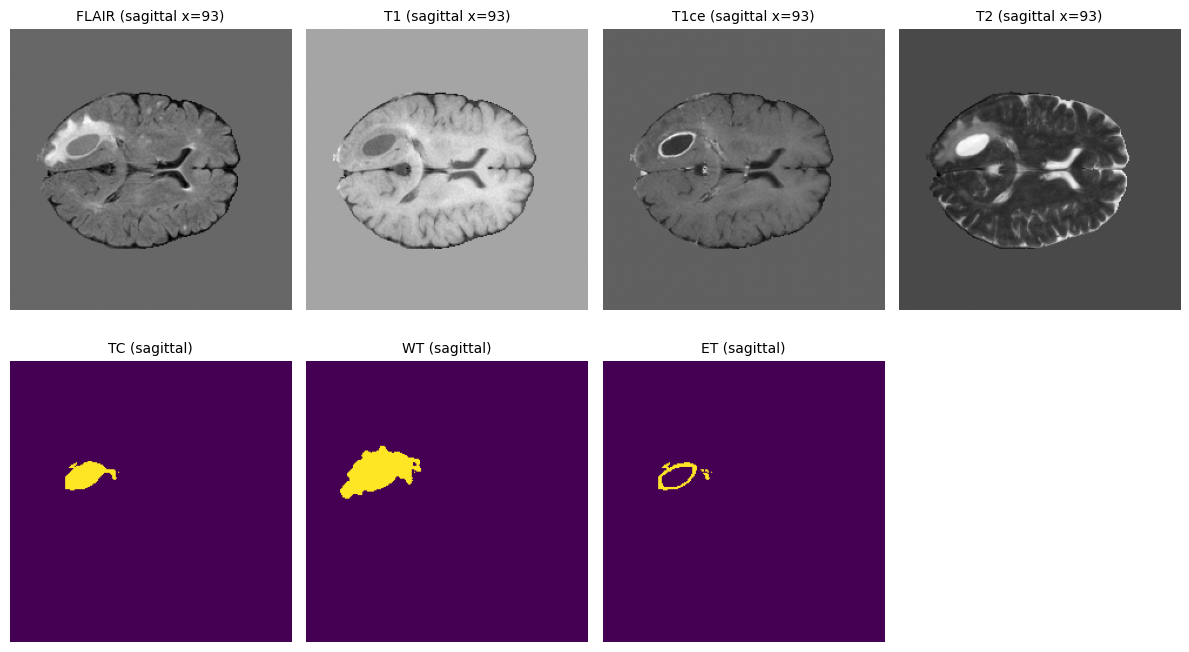

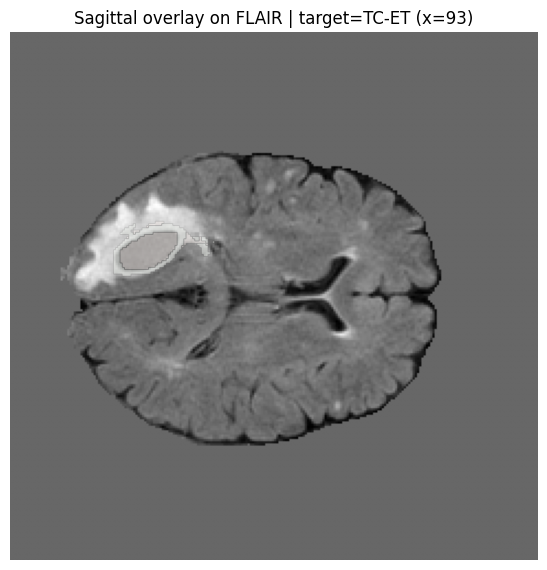

Case 3 | sagittal x=103 (0..154) | plane voxels: TC=430, WT=1379, ET=398, TC_only=32, ET_only=0


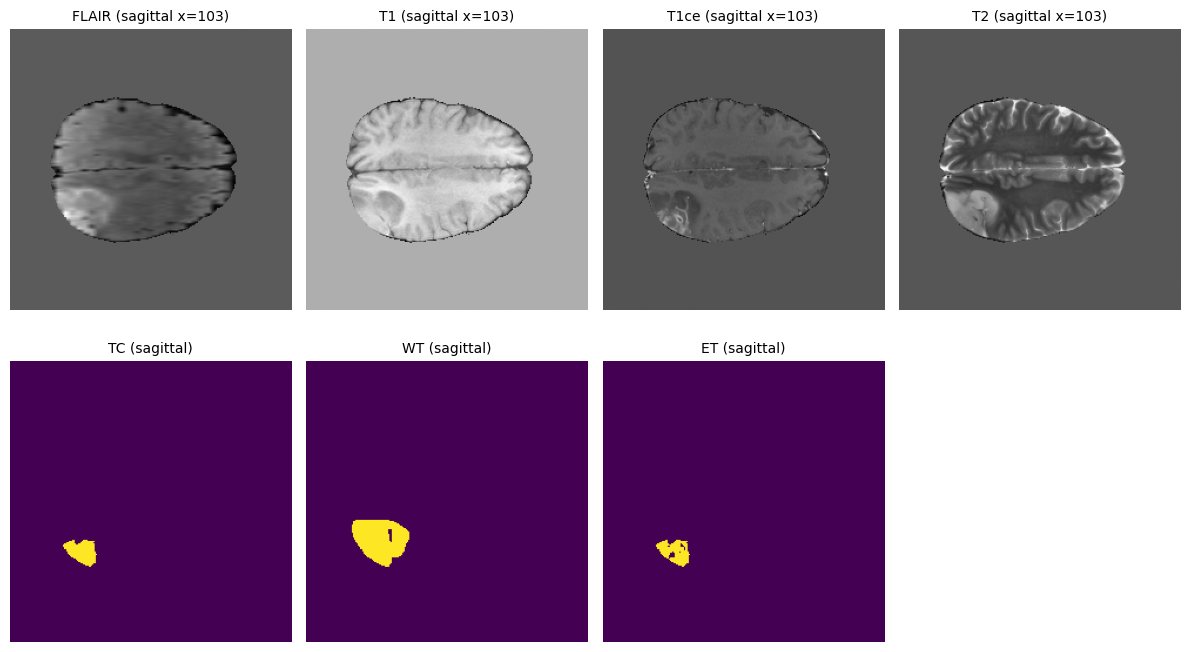

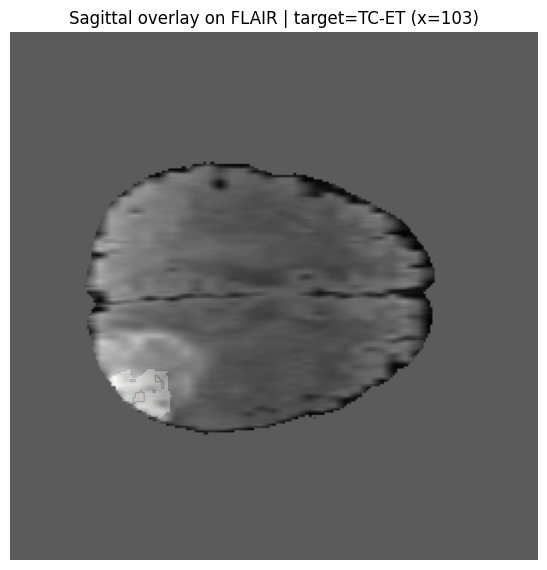

In [18]:
# ─────────────────────────────────────────────────────────────
# Sagittal-only visualization with exclusives  [C, D, H, W]
# ─────────────────────────────────────────────────────────────
import os, numpy as np, torch
import matplotlib.pyplot as plt

MOD_NAMES = ["FLAIR", "T1", "T1ce", "T2"]
LAB_NAMES = ["TC", "WT", "ET"]
LAB_IDX   = {"TC": 0, "WT": 1, "ET": 2}

def pick_sagittal_x(label_3dhw: torch.Tensor, target="ET") -> int:
    """
    Pick sagittal index x (along W axis) maximizing target.
    target in {"ET","WT","TC","TC-ET"}; for "TC-ET" we maximize NCR/NET-only.
    label_3dhw shape: [3, D, H, W]
    """
    tc = (label_3dhw[0] > 0.5)  # [D,H,W]
    et = (label_3dhw[2] > 0.5)
    if target.upper() == "TC-ET":
        tgt = tc & ~et                               # NCR/NET-only
        per_x = tgt.sum(dim=(0,1))                   # sum over D,H -> [W]
    else:
        c = LAB_IDX[target.upper()]
        tgt = (label_3dhw[c] > 0.5)
        per_x = tgt.sum(dim=(0,1))                   # [W]
    x = int(torch.argmax(per_x).item()) if per_x.numel() else 0
    W = label_3dhw.shape[3]
    return max(0, min(x, W - 1))

def visualize_sagittal_exclusive(dataset, index=0, slice_target="TC-ET", overlay_mod="T1ce", alpha=0.35, save_dir=None):
    """
    Shows sagittal slice (left↔right) for a single case.
    slice_target: "ET" | "WT" | "TC" | "TC-ET" (emphasize NCR/NET).
    Overlays: red = TC-only (NCR/NET), green = overlap (ET), blue = ET-only (typically empty).
    """
    sample = dataset[index]
    img = sample["image"]   # [4, D, H, W]
    lab = sample["label"]   # [3, D, H, W]
    C, D, H, W = img.shape

    # choose sagittal index
    x = pick_sagittal_x(lab, target=slice_target)

    img_np = img.cpu().numpy()                      # [4,D,H,W]
    lab_np = (lab.cpu().numpy() > 0.5).astype(np.uint8)  # [3,D,H,W]

    # sagittal background (D×H)
    mods = [img_np[m, :, :, x] for m in range(4)]
    # masks at sagittal slice
    tc = lab_np[0, :, :, x].astype(bool)   # [D,H]
    wt = lab_np[1, :, :, x].astype(bool)
    et = lab_np[2, :, :, x].astype(bool)

    # exclusives (on this sagittal plane)
    tc_only = np.logical_and(tc, ~et)      # NCR/NET-only
    et_only = np.logical_and(et, ~tc)      # should be empty (ET ⊆ TC)
    overlap = np.logical_and(tc, et)       # ET

    print(
        f"Case {index} | sagittal x={x} (0..{W-1}) | plane voxels: "
        f"TC={int(tc.sum())}, WT={int(wt.sum())}, ET={int(et.sum())}, "
        f"TC_only={int(tc_only.sum())}, ET_only={int(et_only.sum())}"
    )

    # ----- Figure 1: 4 modalities + 3 masks at sagittal x
    fig1 = plt.figure(figsize=(12, 7))
    for i, (title, slc) in enumerate(zip(MOD_NAMES, mods)):
        ax = fig1.add_subplot(2, 4, i + 1)
        ax.imshow(slc, cmap="gray"); ax.set_title(f"{title} (sagittal x={x})", fontsize=10); ax.axis("off")
    for i, (title, slc) in enumerate(zip(["TC","WT","ET"], [tc, wt, et])):
        ax = fig1.add_subplot(2, 4, 4 + i + 1)
        ax.imshow(slc, vmin=0, vmax=1); ax.set_title(f"{title} (sagittal)", fontsize=10); ax.axis("off")
    plt.tight_layout()

    # ----- Figure 2: overlay (D×H) with exclusives
    mod_idx = MOD_NAMES.index(overlay_mod)
    bg = img_np[mod_idx, :, :, x]
    fig2, ax = plt.subplots(1, 1, figsize=(5.8, 5.8))
    ax.imshow(bg, cmap="gray")
    ax.imshow(np.ma.masked_where(~tc_only,  tc_only),  cmap="Reds",   alpha=alpha)  # TC-only
    ax.imshow(np.ma.masked_where(~overlap,  overlap),  cmap="Greens", alpha=alpha)  # ET (overlap)
    ax.imshow(np.ma.masked_where(~et_only,  et_only),  cmap="Blues",  alpha=alpha)  # ET-only (likely empty)
    ax.set_title(f"Sagittal overlay on {overlay_mod} | target={slice_target} (x={x})")
    ax.axis("off")
    plt.tight_layout()

    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
        base = os.path.splitext(os.path.basename(str(sample['label'].meta.get('filename_or_obj', f'case_{index}'))))[0]
        fig1.savefig(os.path.join(save_dir, f"{base}_sagittal_mods_masks_x{x}.png"), dpi=150, bbox_inches="tight")
        fig2.savefig(os.path.join(save_dir, f"{base}_sagittal_overlay_{overlay_mod}_x{x}.png"), dpi=150, bbox_inches="tight")

    plt.show()

# Examples:
# emphasize NCR/NET by choosing x with maximal TC-ET
# visualize_sagittal_exclusive(val_dataset, index=0, slice_target="TC-ET", overlay_mod="T1ce", alpha=0.35)
# or emphasize ET:
# visualize_sagittal_exclusive(val_dataset, index=0, slice_target="ET", overlay_mod="T1ce", alpha=0.35)
# sweep a few:
for i in range(1,4):
    visualize_sagittal_exclusive(val_dataset, index=i, slice_target="TC-ET", overlay_mod="FLAIR", alpha=0.35)


# Create Model, Loss, Optimizer (as is from MONAI tutorial)


In [9]:
max_epochs = 300
val_interval = 1
VAL_AMP = True

# create SegResNet, DiceLoss and Adam optimizer
device = torch.device("cuda:0")
global_model = SegResNet(
    blocks_down=[1, 2, 2, 4],
    blocks_up=[1, 1, 1],
    init_filters=16,
    in_channels=4,
    out_channels=3,
    dropout_prob=0.2,
).to(device)
loss_function = DiceLoss(smooth_nr=0, smooth_dr=1e-5, squared_pred=True, to_onehot_y=False, sigmoid=True)
optimizer = torch.optim.Adam(global_model.parameters(), 1e-4, weight_decay=1e-5)

dice_metric = DiceMetric(include_background=True, reduction="mean")
dice_metric_batch = DiceMetric(include_background=True, reduction="mean_batch")

post_trans = Compose([Activations(sigmoid=True), AsDiscrete(threshold=0.5)])


# define inference method
def inference(input):
    def _compute(input):
        return sliding_window_inference(
            inputs=input,
            roi_size=(240, 240, 160),
            sw_batch_size=1,
            predictor=global_model,
            overlap=0.5,
        )

    if VAL_AMP:
        with torch.autocast("cuda"):
            return _compute(input)
    else:
        return _compute(input)


# use amp to accelerate training
scaler = torch.GradScaler("cuda")
# enable cuDNN benchmark
torch.backends.cudnn.benchmark = True

In [10]:
# # Peek one training sample after transforms:
# s0 = train_datasets[idxs_users[0]][0]  # first client, first sample
# img = s0["image"]                       # should be Torch tensor [4, D, H, W]
# lab = s0["label"]                       # should be [3, D, H, W] in your custom order [TC, WT, ET]

# print("image type/shape:", type(img), getattr(img, "shape", None))
# print("label type/shape:", type(lab), getattr(lab, "shape", None))

# # Per-channel stats (if these are nearly identical, something is wrong upstream)
# import torch
# with torch.no_grad():
#     means = [img[c].float().mean().item() for c in range(img.shape[0])]
#     stds  = [img[c].float().std().item()  for c in range(img.shape[0])]
# print("per-modality mean:", [f"{m:.4f}" for m in means])
# print("per-modality std:",  [f"{s:.4f}" for s in stds])

# # Quick correlation check between modalities (if ~1.0 across pairs, they are the same volume)
# def corr(a, b):
#     a = a.flatten().float(); b = b.flatten().float()
#     a = (a - a.mean()) / (a.std() + 1e-8)
#     b = (b - b.mean()) / (b.std() + 1e-8)
#     return float((a * b).mean().item())
# for i in range(4):
#     for j in range(i+1, 4):
#         print(f"corr(mod{i}, mod{j}) =", f"{corr(img[i], img[j]):.3f}")


In [11]:
# # Label uniqueness:
# with torch.no_grad():
#     ch_sums = [int(lab[c].sum().item()) for c in range(lab.shape[0])]
# print("label voxel counts [TC, WT, ET]:", ch_sums)
# # Typically WT >= TC >= ET and they should differ between channels.


# Evaluation function

In [12]:
def evaluate_model(model, dataset, device, batch_size=1):
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
    dice_metric.reset()
    model.eval()
    with torch.no_grad():
        for batch in tqdm(loader, desc="Evaluating"):
            inputs = batch["image"].to(device)
            labels = batch["label"].to(device)          # already multi-channel (WT/TC/ET) floats

            # sliding-window inference (your helper)
            logits = inference(inputs)                  # [B, 3, D, H, W]

            # tensor-wise post-processing (no decollate, no meta juggling)
            preds = torch.sigmoid(logits)
            preds = (preds > 0.5).float()

            # accumulate Dice on tensors directly
            dice_metric(y_pred=preds, y=labels)
            dice_metric_batch(y_pred=preds, y=labels)

    mean_dice = dice_metric.aggregate().item()
    metric_batch = dice_metric_batch.aggregate()
    metric_tc = metric_batch[0].item()
    metric_wt = metric_batch[1].item()
    metric_et = metric_batch[2].item()
    dice_metric.reset()
    dice_metric_batch.reset()
    
    return mean_dice, metric_tc, metric_wt, metric_et
    
print("Dice before any training:", evaluate_model(global_model, val_dataset, device)) # quick sanity check


Evaluating:   0%|                                                                               | 0/505 [00:00<?, ?it/s]Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:306.)
Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:306.)
Evaluating: 100%|█████████████████████████████████████████████████████████████████████| 505/505 [01:53<00:00,  4.46it/s]


Dice before any training: (0.05334309861063957, 0.05396779254078865, 0.08553092181682587, 0.02066398598253727)


# Train federated

In [13]:
from tqdm.auto import tqdm, trange   # trange == tqdm(range())
from collections import OrderedDict

def average_weights(state_dicts, fractions):
    """
    Federated averaging with client fractions (must sum to 1).
    state_dicts: list of state_dicts (same keys)
    fractions:   list of floats, same length, sum≈1
    """
    avg_sd = OrderedDict()
    for k in state_dicts[0].keys():
        avg = 0.0
        for sd, w in zip(state_dicts, fractions):
            avg += sd[k] * w
        avg_sd[k] = avg
    return avg_sd

# ────────────────────────────────────────────────────────────
# 1. one-client update (returns weights + mean loss)          │
# ────────────────────────────────────────────────────────────
def local_train(model, loader, device, lr=1e-4, epochs=1):
    """
    Train a local copy of the global model on one client's DataLoader.
    Uses your DiceLoss (multi-label, sigmoid) and full crops from transforms.
    """
    model = copy.deepcopy(model).to(device)
    model.train()

    # reuse your loss choice; or inline DiceLoss the same way
    crit = DiceLoss(smooth_nr=0, smooth_dr=1e-5, squared_pred=True,
                    to_onehot_y=False, sigmoid=True).to(device)

    opt = torch.optim.Adam(model.parameters(), lr=lr)
    epoch_losses = []

    for _ in range(epochs):
        running = 0.0
        for batch in loader:
            img = batch["image"].to(device)   # [B, 4, D, H, W]
            msk = batch["label"].to(device)   # [B, 3, D, H, W]

            opt.zero_grad(set_to_none=True)
            logits = model(img)               # [B, 3, D, H, W]
            loss = crit(logits, msk)
            loss.backward()
            opt.step()

            running += float(loss.item())
        epoch_losses.append(running / max(1, len(loader)))

    return model.state_dict(), float(np.mean(epoch_losses))


# ────────────────────────────────────────────────────────────
# 2. FedAvg training loop (simple tqdm + clean prints)        │
# ────────────────────────────────────────────────────────────
from tqdm.auto import tqdm, trange

ROUNDS, LOCAL_EPOCHS, LR, BATCH = 100, 1, 1e-4, 1

idxs_users = list(train_datasets.keys())
sizes      = {k: len(ds) for k, ds in train_datasets.items()}
total_n    = sum(sizes.values())
fractions  = [sizes[k] / total_n for k in idxs_users]

print("Dice before any training:", evaluate_model(global_model, val_dataset, device))

best_metric = -1
best_metric_round = -1
best_metrics_rounds_and_time = [[], [], []]
round_loss_values = []
metric_values = []
metric_values_tc = []
metric_values_wt = []
metric_values_et = []

total_start = time.time()
for rnd in trange(1, ROUNDS + 1, desc="Global rounds", position=0, leave=True, dynamic_ncols=True):
    local_weights, client_losses = [], []

    # client bar (line 1)
    for cid in tqdm(idxs_users, desc=" clients", position=1, leave=False, total=len(idxs_users), dynamic_ncols=True):
        loader = DataLoader(train_datasets[cid], batch_size=BATCH, shuffle=True, num_workers=4, pin_memory=True)
        w, loss = local_train(global_model, loader, device, lr=LR, epochs=LOCAL_EPOCHS)
        local_weights.append(w); client_losses.append(loss)

    global_model.load_state_dict(average_weights(local_weights, fractions))

    # eval bar (line 2)
    mean_dice, metric_tc, metric_wt, metric_et = evaluate_model(global_model, val_dataset, device)
    
    metric_values.append(mean_dice)
    metric_values_tc.append(metric_tc)
    metric_values_wt.append(metric_wt)
    metric_values_et.append(metric_et)
    
    mean_loss = float(np.mean(client_losses))
    round_loss_values.append(mean_loss)


    if mean_dice > best_metric:
        best_metric = mean_dice
        best_metric_round = rnd
        best_metrics_rounds_and_time[0].append(best_metric)
        best_metrics_rounds_and_time[1].append(best_metric_round)
        best_metrics_rounds_and_time[2].append(time.time() - total_start)
        torch.save(
            global_model.state_dict(),
            os.path.join(root_dir, "best_metric_model.pth"),
        )
        print("saved new best metric model")
        
    tqdm.write(
        f"Round {rnd:02d}: mean-loss={mean_loss:.4f} "
        f"mean-Dice={mean_dice:.4f}  "
        f"TC-Dice={metric_tc:.4f}  WT-Dice={metric_wt:.4f}  ET-Dice={metric_et:.4f}"
    )



Evaluating:   0%|          | 0/505 [00:01<?, ?it/s]

Dice before any training: (0.05334309861063957, 0.05396779254078865, 0.08553092181682587, 0.02066398598253727)


Global rounds:   0%|                                                                            | 0/100 [00:00…

 clients:   0%|                                                                                  | 0/15 [00:00…

Evaluating:   0%|          | 0/505 [00:00<?, ?it/s]

saved new best metric model
Round 01: mean-loss=0.9383 mean-Dice=0.4002  TC-Dice=0.3262  WT-Dice=0.5066  ET-Dice=0.3699


 clients:   0%|                                                                                  | 0/15 [00:00…

IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out


Evaluating:   0%|          | 0/505 [00:01<?, ?it/s]

saved new best metric model
Round 02: mean-loss=0.8793 mean-Dice=0.4744  TC-Dice=0.3587  WT-Dice=0.5681  ET-Dice=0.4995


 clients:   0%|                                                                                  | 0/15 [00:00…

Evaluating:   0%|          | 0/505 [00:01<?, ?it/s]

saved new best metric model
Round 03: mean-loss=0.8247 mean-Dice=0.6260  TC-Dice=0.4706  WT-Dice=0.7146  ET-Dice=0.6969


 clients:   0%|                                                                                  | 0/15 [00:00…

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcb03f3520>
Traceback (most recent call last):
  File "/home/locolinux2/miniconda3/envs/m_quant_py310/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/home/locolinux2/miniconda3/envs/m_quant_py310/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
  File "/home/locolinux2/miniconda3/envs/m_quant_py310/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcb03f3520>
Traceback (most recent call last):
  File "/home/locolinux2/miniconda3/envs/m_quant_py310/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
 

Evaluating:   0%|          | 0/505 [00:01<?, ?it/s]

saved new best metric model
Round 04: mean-loss=0.7431 mean-Dice=0.7143  TC-Dice=0.6187  WT-Dice=0.7584  ET-Dice=0.7703


 clients:   0%|                                                                                  | 0/15 [00:00…

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcb03f3520>
Traceback (most recent call last):
  File "/home/locolinux2/miniconda3/envs/m_quant_py310/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/home/locolinux2/miniconda3/envs/m_quant_py310/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
  File "/home/locolinux2/miniconda3/envs/m_quant_py310/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcb03f3520>
Traceback (most recent call last):
  File "/home/locolinux2/miniconda3/envs/m_quant_py310/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
 

Evaluating:   0%|          | 0/505 [00:01<?, ?it/s]

saved new best metric model
Round 05: mean-loss=0.6310 mean-Dice=0.7729  TC-Dice=0.7478  WT-Dice=0.8011  ET-Dice=0.7746


 clients:   0%|                                                                                  | 0/15 [00:00…

Evaluating:   0%|          | 0/505 [00:01<?, ?it/s]

saved new best metric model
Round 06: mean-loss=0.5092 mean-Dice=0.8117  TC-Dice=0.7842  WT-Dice=0.8593  ET-Dice=0.7944


 clients:   0%|                                                                                  | 0/15 [00:00…

Evaluating:   0%|          | 0/505 [00:01<?, ?it/s]

Round 07: mean-loss=0.4008 mean-Dice=0.7949  TC-Dice=0.7813  WT-Dice=0.8276  ET-Dice=0.7813


 clients:   0%|                                                                                  | 0/15 [00:00…

Evaluating:   0%|          | 0/505 [00:01<?, ?it/s]

saved new best metric model
Round 08: mean-loss=0.3311 mean-Dice=0.8323  TC-Dice=0.8348  WT-Dice=0.8648  ET-Dice=0.8004


 clients:   0%|                                                                                  | 0/15 [00:00…

Evaluating:   0%|          | 0/505 [00:01<?, ?it/s]

saved new best metric model
Round 09: mean-loss=0.2790 mean-Dice=0.8456  TC-Dice=0.8505  WT-Dice=0.8719  ET-Dice=0.8191


 clients:   0%|                                                                                  | 0/15 [00:00…

Evaluating:   0%|          | 0/505 [00:01<?, ?it/s]

Round 10: mean-loss=0.2476 mean-Dice=0.8223  TC-Dice=0.8014  WT-Dice=0.8660  ET-Dice=0.8038


 clients:   0%|                                                                                  | 0/15 [00:00…

Evaluating:   0%|          | 0/505 [00:01<?, ?it/s]

saved new best metric model
Round 11: mean-loss=0.2349 mean-Dice=0.8562  TC-Dice=0.8710  WT-Dice=0.8752  ET-Dice=0.8263


 clients:   0%|                                                                                  | 0/15 [00:00…

Evaluating:   0%|          | 0/505 [00:01<?, ?it/s]

Round 12: mean-loss=0.2198 mean-Dice=0.8533  TC-Dice=0.8727  WT-Dice=0.8731  ET-Dice=0.8180


 clients:   0%|                                                                                  | 0/15 [00:00…

Evaluating:   0%|          | 0/505 [00:01<?, ?it/s]

Round 13: mean-loss=0.2211 mean-Dice=0.8518  TC-Dice=0.8637  WT-Dice=0.8707  ET-Dice=0.8255


 clients:   0%|                                                                                  | 0/15 [00:00…

Evaluating:   0%|          | 0/505 [00:01<?, ?it/s]

saved new best metric model
Round 14: mean-loss=0.2179 mean-Dice=0.8703  TC-Dice=0.8871  WT-Dice=0.8847  ET-Dice=0.8433


 clients:   0%|                                                                                  | 0/15 [00:00…

Evaluating:   0%|          | 0/505 [00:01<?, ?it/s]

Round 15: mean-loss=0.2112 mean-Dice=0.8603  TC-Dice=0.8840  WT-Dice=0.8629  ET-Dice=0.8396


 clients:   0%|                                                                                  | 0/15 [00:00…

Evaluating:   0%|          | 0/505 [00:01<?, ?it/s]

Round 16: mean-loss=0.2201 mean-Dice=0.8523  TC-Dice=0.8696  WT-Dice=0.8693  ET-Dice=0.8227


 clients:   0%|                                                                                  | 0/15 [00:00…

Evaluating:   0%|          | 0/505 [00:01<?, ?it/s]

Round 17: mean-loss=0.2240 mean-Dice=0.8688  TC-Dice=0.8828  WT-Dice=0.8828  ET-Dice=0.8448


 clients:   0%|                                                                                  | 0/15 [00:00…

Evaluating:   0%|          | 0/505 [00:02<?, ?it/s]

Round 18: mean-loss=0.2137 mean-Dice=0.8635  TC-Dice=0.8731  WT-Dice=0.8861  ET-Dice=0.8357


 clients:   0%|                                                                                  | 0/15 [00:00…

Evaluating:   0%|          | 0/505 [00:01<?, ?it/s]

Round 19: mean-loss=0.2028 mean-Dice=0.8536  TC-Dice=0.8677  WT-Dice=0.8656  ET-Dice=0.8337


 clients:   0%|                                                                                  | 0/15 [00:00…

IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out


Evaluating:   0%|          | 0/505 [00:01<?, ?it/s]

Round 20: mean-loss=0.2114 mean-Dice=0.8674  TC-Dice=0.8825  WT-Dice=0.8815  ET-Dice=0.8421


 clients:   0%|                                                                                  | 0/15 [00:00…

Evaluating:   0%|          | 0/505 [00:01<?, ?it/s]

Round 21: mean-loss=0.2203 mean-Dice=0.8599  TC-Dice=0.8810  WT-Dice=0.8774  ET-Dice=0.8249


 clients:   0%|                                                                                  | 0/15 [00:00…

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcb03f3520>
Traceback (most recent call last):
  File "/home/locolinux2/miniconda3/envs/m_quant_py310/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/home/locolinux2/miniconda3/envs/m_quant_py310/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
  File "/home/locolinux2/miniconda3/envs/m_quant_py310/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcb03f3520>
Traceback (most recent call last):
  File "/home/locolinux2/miniconda3/envs/m_quant_py310/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
 

Evaluating:   0%|          | 0/505 [00:01<?, ?it/s]

Round 22: mean-loss=0.1962 mean-Dice=0.8688  TC-Dice=0.8828  WT-Dice=0.8845  ET-Dice=0.8431


 clients:   0%|                                                                                  | 0/15 [00:00…

Evaluating:   0%|          | 0/505 [00:01<?, ?it/s]

Round 23: mean-loss=0.2033 mean-Dice=0.8549  TC-Dice=0.8630  WT-Dice=0.8792  ET-Dice=0.8277


 clients:   0%|                                                                                  | 0/15 [00:00…

Evaluating:   0%|          | 0/505 [00:02<?, ?it/s]

Round 24: mean-loss=0.2080 mean-Dice=0.8628  TC-Dice=0.8800  WT-Dice=0.8830  ET-Dice=0.8297


 clients:   0%|                                                                                  | 0/15 [00:00…

Evaluating:   0%|          | 0/505 [00:01<?, ?it/s]

saved new best metric model
Round 25: mean-loss=0.2037 mean-Dice=0.8709  TC-Dice=0.8887  WT-Dice=0.8808  ET-Dice=0.8473


 clients:   0%|                                                                                  | 0/15 [00:00…

Evaluating:   0%|          | 0/505 [00:01<?, ?it/s]

saved new best metric model
Round 26: mean-loss=0.1975 mean-Dice=0.8780  TC-Dice=0.8992  WT-Dice=0.8933  ET-Dice=0.8454


 clients:   0%|                                                                                  | 0/15 [00:00…

Evaluating:   0%|          | 0/505 [00:01<?, ?it/s]

Round 27: mean-loss=0.2096 mean-Dice=0.8669  TC-Dice=0.8850  WT-Dice=0.8822  ET-Dice=0.8381


 clients:   0%|                                                                                  | 0/15 [00:00…

Evaluating:   0%|          | 0/505 [00:01<?, ?it/s]

Round 28: mean-loss=0.2093 mean-Dice=0.8675  TC-Dice=0.8756  WT-Dice=0.8911  ET-Dice=0.8391


 clients:   0%|                                                                                  | 0/15 [00:00…

Evaluating:   0%|          | 0/505 [00:01<?, ?it/s]

Round 29: mean-loss=0.2057 mean-Dice=0.8740  TC-Dice=0.8922  WT-Dice=0.8858  ET-Dice=0.8489


 clients:   0%|                                                                                  | 0/15 [00:00…

Evaluating:   0%|          | 0/505 [00:01<?, ?it/s]

Round 30: mean-loss=0.2019 mean-Dice=0.8767  TC-Dice=0.9005  WT-Dice=0.8870  ET-Dice=0.8474


 clients:   0%|                                                                                  | 0/15 [00:00…

Evaluating:   0%|          | 0/505 [00:02<?, ?it/s]

Round 31: mean-loss=0.1997 mean-Dice=0.8475  TC-Dice=0.8606  WT-Dice=0.8692  ET-Dice=0.8179


 clients:   0%|                                                                                  | 0/15 [00:00…

Evaluating:   0%|          | 0/505 [00:02<?, ?it/s]

saved new best metric model
Round 32: mean-loss=0.2032 mean-Dice=0.8799  TC-Dice=0.8959  WT-Dice=0.8906  ET-Dice=0.8573


 clients:   0%|                                                                                  | 0/15 [00:00…

Evaluating:   0%|          | 0/505 [00:01<?, ?it/s]

Round 33: mean-loss=0.2034 mean-Dice=0.8719  TC-Dice=0.8914  WT-Dice=0.8787  ET-Dice=0.8506


 clients:   0%|                                                                                  | 0/15 [00:00…

Evaluating:   0%|          | 0/505 [00:01<?, ?it/s]

saved new best metric model
Round 34: mean-loss=0.2065 mean-Dice=0.8817  TC-Dice=0.8963  WT-Dice=0.9001  ET-Dice=0.8523


 clients:   0%|                                                                                  | 0/15 [00:00…

Evaluating:   0%|          | 0/505 [00:01<?, ?it/s]

saved new best metric model
Round 35: mean-loss=0.1987 mean-Dice=0.8841  TC-Dice=0.9021  WT-Dice=0.8945  ET-Dice=0.8599


 clients:   0%|                                                                                  | 0/15 [00:00…

Evaluating:   0%|          | 0/505 [00:01<?, ?it/s]

Round 36: mean-loss=0.1900 mean-Dice=0.8803  TC-Dice=0.8987  WT-Dice=0.8898  ET-Dice=0.8566


 clients:   0%|                                                                                  | 0/15 [00:00…

Evaluating:   0%|          | 0/505 [00:01<?, ?it/s]

Round 37: mean-loss=0.2016 mean-Dice=0.8574  TC-Dice=0.8653  WT-Dice=0.8805  ET-Dice=0.8299


 clients:   0%|                                                                                  | 0/15 [00:00…

Evaluating:   0%|          | 0/505 [00:01<?, ?it/s]

Round 38: mean-loss=0.1981 mean-Dice=0.8625  TC-Dice=0.8780  WT-Dice=0.8817  ET-Dice=0.8323


 clients:   0%|                                                                                  | 0/15 [00:00…

Evaluating:   0%|          | 0/505 [00:01<?, ?it/s]

Round 39: mean-loss=0.2088 mean-Dice=0.8808  TC-Dice=0.9002  WT-Dice=0.8977  ET-Dice=0.8488


 clients:   0%|                                                                                  | 0/15 [00:00…

Evaluating:   0%|          | 0/505 [00:01<?, ?it/s]

Round 40: mean-loss=0.1971 mean-Dice=0.8807  TC-Dice=0.8989  WT-Dice=0.8924  ET-Dice=0.8547


 clients:   0%|                                                                                  | 0/15 [00:00…

Evaluating:   0%|          | 0/505 [00:01<?, ?it/s]

saved new best metric model
Round 41: mean-loss=0.1950 mean-Dice=0.8877  TC-Dice=0.9047  WT-Dice=0.9027  ET-Dice=0.8595


 clients:   0%|                                                                                  | 0/15 [00:00…

Evaluating:   0%|          | 0/505 [00:01<?, ?it/s]

Round 42: mean-loss=0.1914 mean-Dice=0.8742  TC-Dice=0.8924  WT-Dice=0.8894  ET-Dice=0.8461


 clients:   0%|                                                                                  | 0/15 [00:00…

Evaluating:   0%|          | 0/505 [00:01<?, ?it/s]

Round 43: mean-loss=0.1956 mean-Dice=0.8774  TC-Dice=0.8834  WT-Dice=0.8972  ET-Dice=0.8559


 clients:   0%|                                                                                  | 0/15 [00:00…

Evaluating:   0%|          | 0/505 [00:01<?, ?it/s]

saved new best metric model
Round 44: mean-loss=0.1926 mean-Dice=0.8888  TC-Dice=0.9052  WT-Dice=0.8982  ET-Dice=0.8683


 clients:   0%|                                                                                  | 0/15 [00:00…

Evaluating:   0%|          | 0/505 [00:01<?, ?it/s]

Round 45: mean-loss=0.1978 mean-Dice=0.8888  TC-Dice=0.9044  WT-Dice=0.9043  ET-Dice=0.8619


 clients:   0%|                                                                                  | 0/15 [00:00…

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcb03f3520>
Traceback (most recent call last):
  File "/home/locolinux2/miniconda3/envs/m_quant_py310/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/home/locolinux2/miniconda3/envs/m_quant_py310/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
  File "/home/locolinux2/miniconda3/envs/m_quant_py310/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcb03f3520>
Traceback (most recent call last):
  File "/home/locolinux2/miniconda3/envs/m_quant_py310/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
 

Evaluating:   0%|          | 0/505 [00:02<?, ?it/s]

Round 46: mean-loss=0.1923 mean-Dice=0.8875  TC-Dice=0.9040  WT-Dice=0.8989  ET-Dice=0.8640


 clients:   0%|                                                                                  | 0/15 [00:00…

Evaluating:   0%|          | 0/505 [00:01<?, ?it/s]

Round 47: mean-loss=0.1893 mean-Dice=0.8787  TC-Dice=0.9003  WT-Dice=0.8858  ET-Dice=0.8548


 clients:   0%|                                                                                  | 0/15 [00:00…

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcb03f3520>
Traceback (most recent call last):
  File "/home/locolinux2/miniconda3/envs/m_quant_py310/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/home/locolinux2/miniconda3/envs/m_quant_py310/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
  File "/home/locolinux2/miniconda3/envs/m_quant_py310/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcb03f3520>
Traceback (most recent call last):
  File "/home/locolinux2/miniconda3/envs/m_quant_py310/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
 

Evaluating:   0%|          | 0/505 [00:01<?, ?it/s]

Round 48: mean-loss=0.1918 mean-Dice=0.8873  TC-Dice=0.8985  WT-Dice=0.9022  ET-Dice=0.8653


 clients:   0%|                                                                                  | 0/15 [00:00…

Evaluating:   0%|          | 0/505 [00:01<?, ?it/s]

Round 49: mean-loss=0.1890 mean-Dice=0.8863  TC-Dice=0.9011  WT-Dice=0.9022  ET-Dice=0.8594


 clients:   0%|                                                                                  | 0/15 [00:00…

Evaluating:   0%|          | 0/505 [00:01<?, ?it/s]

Round 50: mean-loss=0.1938 mean-Dice=0.8873  TC-Dice=0.9050  WT-Dice=0.8995  ET-Dice=0.8623


 clients:   0%|                                                                                  | 0/15 [00:00…

Evaluating:   0%|          | 0/505 [00:01<?, ?it/s]

Round 51: mean-loss=0.1970 mean-Dice=0.8850  TC-Dice=0.9041  WT-Dice=0.8941  ET-Dice=0.8609


 clients:   0%|                                                                                  | 0/15 [00:00…

Evaluating:   0%|          | 0/505 [00:01<?, ?it/s]

Round 52: mean-loss=0.1895 mean-Dice=0.8833  TC-Dice=0.9023  WT-Dice=0.9013  ET-Dice=0.8505


 clients:   0%|                                                                                  | 0/15 [00:00…

Evaluating:   0%|          | 0/505 [00:01<?, ?it/s]

Round 53: mean-loss=0.1918 mean-Dice=0.8851  TC-Dice=0.9052  WT-Dice=0.9012  ET-Dice=0.8536


 clients:   0%|                                                                                  | 0/15 [00:00…

Evaluating:   0%|          | 0/505 [00:01<?, ?it/s]

saved new best metric model
Round 54: mean-loss=0.1999 mean-Dice=0.8893  TC-Dice=0.9104  WT-Dice=0.8975  ET-Dice=0.8640


 clients:   0%|                                                                                  | 0/15 [00:00…

Evaluating:   0%|          | 0/505 [00:01<?, ?it/s]

Round 55: mean-loss=0.1917 mean-Dice=0.8718  TC-Dice=0.8811  WT-Dice=0.8954  ET-Dice=0.8424


 clients:   0%|                                                                                  | 0/15 [00:00…

Evaluating:   0%|          | 0/505 [00:01<?, ?it/s]

Round 56: mean-loss=0.1943 mean-Dice=0.8786  TC-Dice=0.8952  WT-Dice=0.8951  ET-Dice=0.8500


 clients:   0%|                                                                                  | 0/15 [00:00…

Evaluating:   0%|          | 0/505 [00:01<?, ?it/s]

saved new best metric model
Round 57: mean-loss=0.2067 mean-Dice=0.8908  TC-Dice=0.9089  WT-Dice=0.8999  ET-Dice=0.8679


 clients:   0%|                                                                                  | 0/15 [00:00…

Evaluating:   0%|          | 0/505 [00:01<?, ?it/s]

Round 58: mean-loss=0.1872 mean-Dice=0.8882  TC-Dice=0.8999  WT-Dice=0.9046  ET-Dice=0.8642


 clients:   0%|                                                                                  | 0/15 [00:00…

Evaluating:   0%|          | 0/505 [00:02<?, ?it/s]

Round 59: mean-loss=0.1922 mean-Dice=0.8908  TC-Dice=0.9081  WT-Dice=0.8998  ET-Dice=0.8689


 clients:   0%|                                                                                  | 0/15 [00:00…

Evaluating:   0%|          | 0/505 [00:01<?, ?it/s]

Round 60: mean-loss=0.1961 mean-Dice=0.8847  TC-Dice=0.9099  WT-Dice=0.8840  ET-Dice=0.8651


 clients:   0%|                                                                                  | 0/15 [00:00…

Evaluating:   0%|          | 0/505 [00:01<?, ?it/s]

Round 61: mean-loss=0.1896 mean-Dice=0.8891  TC-Dice=0.9095  WT-Dice=0.8963  ET-Dice=0.8668


 clients:   0%|                                                                                  | 0/15 [00:00…

Evaluating:   0%|          | 0/505 [00:01<?, ?it/s]

Round 62: mean-loss=0.1830 mean-Dice=0.8900  TC-Dice=0.9076  WT-Dice=0.9014  ET-Dice=0.8664


 clients:   0%|                                                                                  | 0/15 [00:00…

Evaluating:   0%|          | 0/505 [00:01<?, ?it/s]

Round 63: mean-loss=0.1890 mean-Dice=0.8898  TC-Dice=0.9060  WT-Dice=0.9072  ET-Dice=0.8605


 clients:   0%|                                                                                  | 0/15 [00:00…

Evaluating:   0%|          | 0/505 [00:01<?, ?it/s]

saved new best metric model
Round 64: mean-loss=0.1969 mean-Dice=0.8963  TC-Dice=0.9113  WT-Dice=0.9113  ET-Dice=0.8705


 clients:   0%|                                                                                  | 0/15 [00:00…

IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out


Evaluating:   0%|          | 0/505 [00:02<?, ?it/s]

Round 65: mean-loss=0.1849 mean-Dice=0.8950  TC-Dice=0.9118  WT-Dice=0.9070  ET-Dice=0.8701


 clients:   0%|                                                                                  | 0/15 [00:00…

Evaluating:   0%|          | 0/505 [00:01<?, ?it/s]

Round 66: mean-loss=0.1866 mean-Dice=0.8918  TC-Dice=0.9076  WT-Dice=0.9076  ET-Dice=0.8640


 clients:   0%|                                                                                  | 0/15 [00:00…

Evaluating:   0%|          | 0/505 [00:01<?, ?it/s]

saved new best metric model
Round 67: mean-loss=0.1866 mean-Dice=0.8971  TC-Dice=0.9137  WT-Dice=0.9068  ET-Dice=0.8746


 clients:   0%|                                                                                  | 0/15 [00:00…

Evaluating:   0%|          | 0/505 [00:01<?, ?it/s]

saved new best metric model
Round 68: mean-loss=0.1919 mean-Dice=0.8978  TC-Dice=0.9131  WT-Dice=0.9110  ET-Dice=0.8739


 clients:   0%|                                                                                  | 0/15 [00:00…

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcb03f3520>
Traceback (most recent call last):
  File "/home/locolinux2/miniconda3/envs/m_quant_py310/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/home/locolinux2/miniconda3/envs/m_quant_py310/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
  File "/home/locolinux2/miniconda3/envs/m_quant_py310/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcb03f3520>
Traceback (most recent call last):
  File "/home/locolinux2/miniconda3/envs/m_quant_py310/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
 

Evaluating:   0%|          | 0/505 [00:01<?, ?it/s]

Round 69: mean-loss=0.1868 mean-Dice=0.8972  TC-Dice=0.9143  WT-Dice=0.9093  ET-Dice=0.8719


 clients:   0%|                                                                                  | 0/15 [00:00…

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcb03f3520>
Traceback (most recent call last):
  File "/home/locolinux2/miniconda3/envs/m_quant_py310/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/home/locolinux2/miniconda3/envs/m_quant_py310/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
  File "/home/locolinux2/miniconda3/envs/m_quant_py310/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcb03f3520>
Traceback (most recent call last):
  File "/home/locolinux2/miniconda3/envs/m_quant_py310/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
 

Evaluating:   0%|          | 0/505 [00:01<?, ?it/s]

Round 70: mean-loss=0.1845 mean-Dice=0.8918  TC-Dice=0.9114  WT-Dice=0.9006  ET-Dice=0.8670


 clients:   0%|                                                                                  | 0/15 [00:00…

Evaluating:   0%|          | 0/505 [00:01<?, ?it/s]

Round 71: mean-loss=0.1888 mean-Dice=0.8948  TC-Dice=0.9140  WT-Dice=0.9003  ET-Dice=0.8745


 clients:   0%|                                                                                  | 0/15 [00:00…

Evaluating:   0%|          | 0/505 [00:01<?, ?it/s]

Round 72: mean-loss=0.1928 mean-Dice=0.8954  TC-Dice=0.9126  WT-Dice=0.9089  ET-Dice=0.8691


 clients:   0%|                                                                                  | 0/15 [00:00…

Evaluating:   0%|          | 0/505 [00:01<?, ?it/s]

saved new best metric model
Round 73: mean-loss=0.1829 mean-Dice=0.8979  TC-Dice=0.9098  WT-Dice=0.9115  ET-Dice=0.8757


 clients:   0%|                                                                                  | 0/15 [00:00…

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcb03f3520>
Traceback (most recent call last):
  File "/home/locolinux2/miniconda3/envs/m_quant_py310/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/home/locolinux2/miniconda3/envs/m_quant_py310/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
  File "/home/locolinux2/miniconda3/envs/m_quant_py310/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcb03f3520>
Traceback (most recent call last):
  File "/home/locolinux2/miniconda3/envs/m_quant_py310/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
 

Evaluating:   0%|          | 0/505 [00:01<?, ?it/s]

Round 74: mean-loss=0.1844 mean-Dice=0.8960  TC-Dice=0.9148  WT-Dice=0.9027  ET-Dice=0.8752


 clients:   0%|                                                                                  | 0/15 [00:00…

Evaluating:   0%|          | 0/505 [00:01<?, ?it/s]

Round 75: mean-loss=0.1876 mean-Dice=0.8944  TC-Dice=0.9100  WT-Dice=0.9017  ET-Dice=0.8754


 clients:   0%|                                                                                  | 0/15 [00:00…

Evaluating:   0%|          | 0/505 [00:02<?, ?it/s]

saved new best metric model
Round 76: mean-loss=0.1814 mean-Dice=0.8981  TC-Dice=0.9132  WT-Dice=0.9088  ET-Dice=0.8758


 clients:   0%|                                                                                  | 0/15 [00:00…

Evaluating:   0%|          | 0/505 [00:02<?, ?it/s]

saved new best metric model
Round 77: mean-loss=0.1861 mean-Dice=0.8995  TC-Dice=0.9134  WT-Dice=0.9078  ET-Dice=0.8808


 clients:   0%|                                                                                  | 0/15 [00:00…

Evaluating:   0%|          | 0/505 [00:01<?, ?it/s]

saved new best metric model
Round 78: mean-loss=0.1864 mean-Dice=0.9010  TC-Dice=0.9148  WT-Dice=0.9126  ET-Dice=0.8794


 clients:   0%|                                                                                  | 0/15 [00:00…

Evaluating:   0%|          | 0/505 [00:01<?, ?it/s]

Round 79: mean-loss=0.1792 mean-Dice=0.8987  TC-Dice=0.9137  WT-Dice=0.9065  ET-Dice=0.8794


 clients:   0%|                                                                                  | 0/15 [00:00…

Evaluating:   0%|          | 0/505 [00:01<?, ?it/s]

Round 80: mean-loss=0.1838 mean-Dice=0.8934  TC-Dice=0.9077  WT-Dice=0.9101  ET-Dice=0.8657


 clients:   0%|                                                                                  | 0/15 [00:00…

Evaluating:   0%|          | 0/505 [00:01<?, ?it/s]

saved new best metric model
Round 81: mean-loss=0.1860 mean-Dice=0.9017  TC-Dice=0.9175  WT-Dice=0.9107  ET-Dice=0.8811


 clients:   0%|                                                                                  | 0/15 [00:00…

Evaluating:   0%|          | 0/505 [00:01<?, ?it/s]

Round 82: mean-loss=0.1954 mean-Dice=0.8992  TC-Dice=0.9129  WT-Dice=0.9143  ET-Dice=0.8739


 clients:   0%|                                                                                  | 0/15 [00:00…

Evaluating:   0%|          | 0/505 [00:01<?, ?it/s]

Round 83: mean-loss=0.1835 mean-Dice=0.8963  TC-Dice=0.9125  WT-Dice=0.9047  ET-Dice=0.8755


 clients:   0%|                                                                                  | 0/15 [00:00…

Evaluating:   0%|          | 0/505 [00:01<?, ?it/s]

Round 84: mean-loss=0.1755 mean-Dice=0.8939  TC-Dice=0.9111  WT-Dice=0.9113  ET-Dice=0.8628


 clients:   0%|                                                                                  | 0/15 [00:00…

Evaluating:   0%|          | 0/505 [00:01<?, ?it/s]

Round 85: mean-loss=0.1810 mean-Dice=0.8931  TC-Dice=0.9056  WT-Dice=0.9089  ET-Dice=0.8682


 clients:   0%|                                                                                  | 0/15 [00:00…

Evaluating:   0%|          | 0/505 [00:01<?, ?it/s]

Round 86: mean-loss=0.1909 mean-Dice=0.8942  TC-Dice=0.9051  WT-Dice=0.9082  ET-Dice=0.8728


 clients:   0%|                                                                                  | 0/15 [00:00…

Evaluating:   0%|          | 0/505 [00:01<?, ?it/s]

Round 87: mean-loss=0.1762 mean-Dice=0.8998  TC-Dice=0.9115  WT-Dice=0.9133  ET-Dice=0.8781


 clients:   0%|                                                                                  | 0/15 [00:00…

Evaluating:   0%|          | 0/505 [00:01<?, ?it/s]

Round 88: mean-loss=0.1786 mean-Dice=0.9010  TC-Dice=0.9179  WT-Dice=0.9096  ET-Dice=0.8797


 clients:   0%|                                                                                  | 0/15 [00:00…

Evaluating:   0%|          | 0/505 [00:01<?, ?it/s]

Round 89: mean-loss=0.1844 mean-Dice=0.9002  TC-Dice=0.9127  WT-Dice=0.9126  ET-Dice=0.8791


 clients:   0%|                                                                                  | 0/15 [00:00…

Evaluating:   0%|          | 0/505 [00:01<?, ?it/s]

Round 90: mean-loss=0.1848 mean-Dice=0.8958  TC-Dice=0.9104  WT-Dice=0.9070  ET-Dice=0.8736


 clients:   0%|                                                                                  | 0/15 [00:00…

Evaluating:   0%|          | 0/505 [00:01<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcb03f3520>
Traceback (most recent call last):
  File "/home/locolinux2/miniconda3/envs/m_quant_py310/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/home/locolinux2/miniconda3/envs/m_quant_py310/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
  File "/home/locolinux2/miniconda3/envs/m_quant_py310/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcb03f3520>
Traceback (most recent call last):
  File "/home/locolinux2/miniconda3/envs/m_quant_py310/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
 

Round 91: mean-loss=0.1826 mean-Dice=0.9016  TC-Dice=0.9174  WT-Dice=0.9114  ET-Dice=0.8797


 clients:   0%|                                                                                  | 0/15 [00:00…

Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcb03f3520>Traceback (most recent call last):
  File "/home/locolinux2/miniconda3/envs/m_quant_py310/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/home/locolinux2/miniconda3/envs/m_quant_py310/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
  File "/home/locolinux2/miniconda3/envs/m_quant_py310/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcb03f3520>
Traceback (most recent call last):
  File "/home/locolinux2/miniconda3/envs/m_quant_py310/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
 

Evaluating:   0%|          | 0/505 [00:01<?, ?it/s]

Round 92: mean-loss=0.1840 mean-Dice=0.9017  TC-Dice=0.9146  WT-Dice=0.9156  ET-Dice=0.8788


 clients:   0%|                                                                                  | 0/15 [00:00…

Evaluating:   0%|          | 0/505 [00:01<?, ?it/s]

Round 93: mean-loss=0.1823 mean-Dice=0.9006  TC-Dice=0.9161  WT-Dice=0.9130  ET-Dice=0.8762


 clients:   0%|                                                                                  | 0/15 [00:00…

Evaluating:   0%|          | 0/505 [00:01<?, ?it/s]

Round 94: mean-loss=0.1817 mean-Dice=0.8966  TC-Dice=0.9132  WT-Dice=0.9114  ET-Dice=0.8689


 clients:   0%|                                                                                  | 0/15 [00:00…

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcb03f3520>
Traceback (most recent call last):
  File "/home/locolinux2/miniconda3/envs/m_quant_py310/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/home/locolinux2/miniconda3/envs/m_quant_py310/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
  File "/home/locolinux2/miniconda3/envs/m_quant_py310/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcb03f3520>
Traceback (most recent call last):
  File "/home/locolinux2/miniconda3/envs/m_quant_py310/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
 

Evaluating:   0%|          | 0/505 [00:01<?, ?it/s]

Round 95: mean-loss=0.1908 mean-Dice=0.8985  TC-Dice=0.9092  WT-Dice=0.9128  ET-Dice=0.8768


 clients:   0%|                                                                                  | 0/15 [00:00…

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcb03f3520>
Traceback (most recent call last):
  File "/home/locolinux2/miniconda3/envs/m_quant_py310/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/home/locolinux2/miniconda3/envs/m_quant_py310/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
  File "/home/locolinux2/miniconda3/envs/m_quant_py310/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcb03f3520>
Traceback (most recent call last):
  File "/home/locolinux2/miniconda3/envs/m_quant_py310/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
 

Evaluating:   0%|          | 0/505 [00:01<?, ?it/s]

Round 96: mean-loss=0.1773 mean-Dice=0.8988  TC-Dice=0.9141  WT-Dice=0.9097  ET-Dice=0.8762


 clients:   0%|                                                                                  | 0/15 [00:00…

Evaluating:   0%|          | 0/505 [00:01<?, ?it/s]

saved new best metric model
Round 97: mean-loss=0.1814 mean-Dice=0.9021  TC-Dice=0.9154  WT-Dice=0.9136  ET-Dice=0.8807


 clients:   0%|                                                                                  | 0/15 [00:00…

Evaluating:   0%|          | 0/505 [00:01<?, ?it/s]

Round 98: mean-loss=0.1840 mean-Dice=0.9014  TC-Dice=0.9160  WT-Dice=0.9090  ET-Dice=0.8834


 clients:   0%|                                                                                  | 0/15 [00:00…

Evaluating:   0%|          | 0/505 [00:01<?, ?it/s]

Round 99: mean-loss=0.1857 mean-Dice=0.9017  TC-Dice=0.9145  WT-Dice=0.9146  ET-Dice=0.8802


 clients:   0%|                                                                                  | 0/15 [00:00…

Evaluating:   0%|          | 0/505 [00:01<?, ?it/s]

Round 100: mean-loss=0.1795 mean-Dice=0.9014  TC-Dice=0.9111  WT-Dice=0.9177  ET-Dice=0.8792


Saved curves to: ./seg_ckpts/plots/training_curves.csv


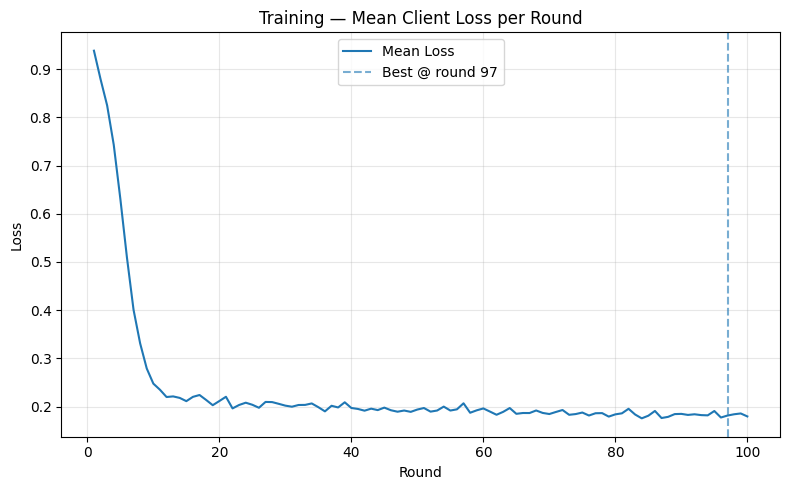

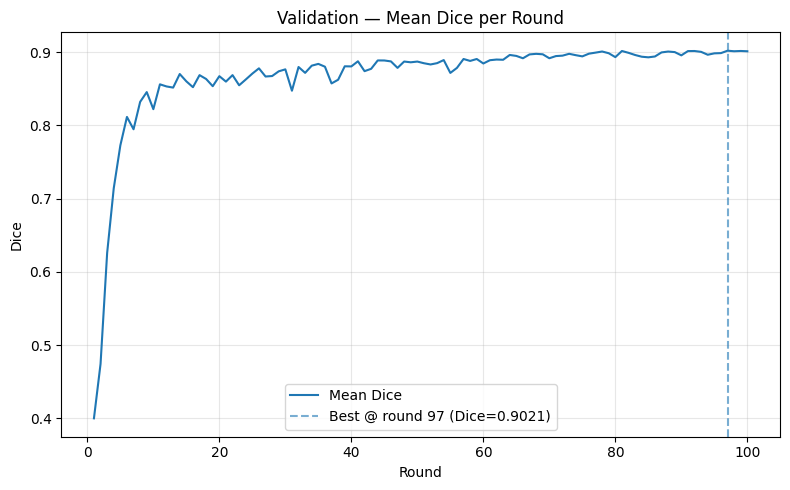

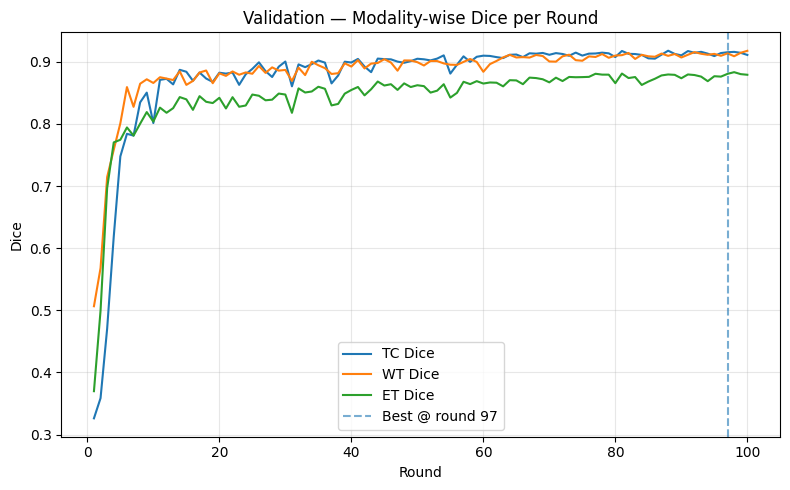

Plots saved in: ./seg_ckpts/plots


In [14]:
# ─────────────────────────────────────────────────────────────
# Plot training curves (loss, mean Dice, and class-wise Dice)
# ─────────────────────────────────────────────────────────────
import os, math, time
import numpy as np
import matplotlib.pyplot as plt

# Optional: smoothing (moving average). Set SMOOTH=0 to disable.
SMOOTH = 0  # e.g., 3 or 5 for light smoothing

def _moving_avg(x, k):
    if k is None or k <= 1:
        return np.asarray(x, dtype=float)
    x = np.asarray(x, dtype=float)
    kernel = np.ones(k, dtype=float) / k
    # pad on both sides to keep length
    pad = k // 2
    xpad = np.pad(x, (pad, pad), mode="edge")
    return np.convolve(xpad, kernel, mode="valid")[: len(x)]

rounds = np.arange(1, len(round_loss_values) + 1, dtype=int)

loss_curve     = _moving_avg(round_loss_values, SMOOTH)
mean_dice_curve= _moving_avg(metric_values, SMOOTH)
tc_curve       = _moving_avg(metric_values_tc, SMOOTH)
wt_curve       = _moving_avg(metric_values_wt, SMOOTH)
et_curve       = _moving_avg(metric_values_et, SMOOTH)

# Some runs may not have found a "best" yet; guard accordingly.
_has_best = "best_metric" in globals() and "best_metric_round" in globals() and best_metric_round is not None and best_metric_round != -1

# Where to save artifacts
plots_dir = os.path.join(root_dir if "root_dir" in globals() else ".", "plots")
os.makedirs(plots_dir, exist_ok=True)
csv_path = os.path.join(plots_dir, "training_curves.csv")

# Save curves as CSV for reproducibility
try:
    import pandas as pd
    df = pd.DataFrame({
        "round": rounds,
        "mean_loss": np.asarray(round_loss_values, dtype=float),
        "mean_dice": np.asarray(metric_values, dtype=float),
        "tc_dice":   np.asarray(metric_values_tc, dtype=float),
        "wt_dice":   np.asarray(metric_values_wt, dtype=float),
        "et_dice":   np.asarray(metric_values_et, dtype=float),
    })
    df.to_csv(csv_path, index=False)
    print(f"Saved curves to: {csv_path}")
except Exception as e:
    print(f"(Skipping CSV save; pandas not available or error: {e})")

# 1) Mean client loss per round
plt.figure(figsize=(8, 5))
plt.plot(rounds, loss_curve, label="Mean Loss")
if _has_best and 1 <= best_metric_round <= rounds[-1]:
    plt.axvline(best_metric_round, linestyle="--", alpha=0.6, label=f"Best @ round {best_metric_round}")
plt.xlabel("Round")
plt.ylabel("Loss")
plt.title("Training — Mean Client Loss per Round")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(plots_dir, "loss_curve.png"), dpi=150)
plt.show()

# 2) Mean Dice (overall)
plt.figure(figsize=(8, 5))
plt.plot(rounds, mean_dice_curve, label="Mean Dice")
if _has_best and 1 <= best_metric_round <= rounds[-1]:
    plt.axvline(best_metric_round, linestyle="--", alpha=0.6, label=f"Best @ round {best_metric_round} (Dice={best_metric:.4f})")
plt.xlabel("Round")
plt.ylabel("Dice")
plt.title("Validation — Mean Dice per Round")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(plots_dir, "mean_dice_curve.png"), dpi=150)
plt.show()

# 3) Class-wise Dice (TC / WT / ET)
plt.figure(figsize=(8, 5))
plt.plot(rounds, tc_curve, label="TC Dice")
plt.plot(rounds, wt_curve, label="WT Dice")
plt.plot(rounds, et_curve, label="ET Dice")
if _has_best and 1 <= best_metric_round <= rounds[-1]:
    plt.axvline(best_metric_round, linestyle="--", alpha=0.6, label=f"Best @ round {best_metric_round}")
plt.xlabel("Round")
plt.ylabel("Dice")
plt.title("Validation — Modality-wise Dice per Round")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(plots_dir, "classwise_dice_curve.png"), dpi=150)
plt.show()

print("Plots saved in:", plots_dir)


Loaded best weights from: ./seg_ckpts/best_metric_model.pth

Per-class Dice on first 5 val cases:
  idx 00 ▸ TC 0.953 | WT 0.901 | ET 0.955 | mean 0.936
  idx 01 ▸ TC 0.955 | WT 0.918 | ET 0.919 | mean 0.931
  idx 02 ▸ TC 0.949 | WT 0.951 | ET 0.929 | mean 0.943
  idx 03 ▸ TC 0.948 | WT 0.957 | ET 0.937 | mean 0.948
  idx 04 ▸ TC 0.919 | WT 0.913 | ET 0.866 | mean 0.899
Case 0 | Dice — TC:0.953  WT:0.901  ET:0.955  mean:0.936 | sagittal x=58


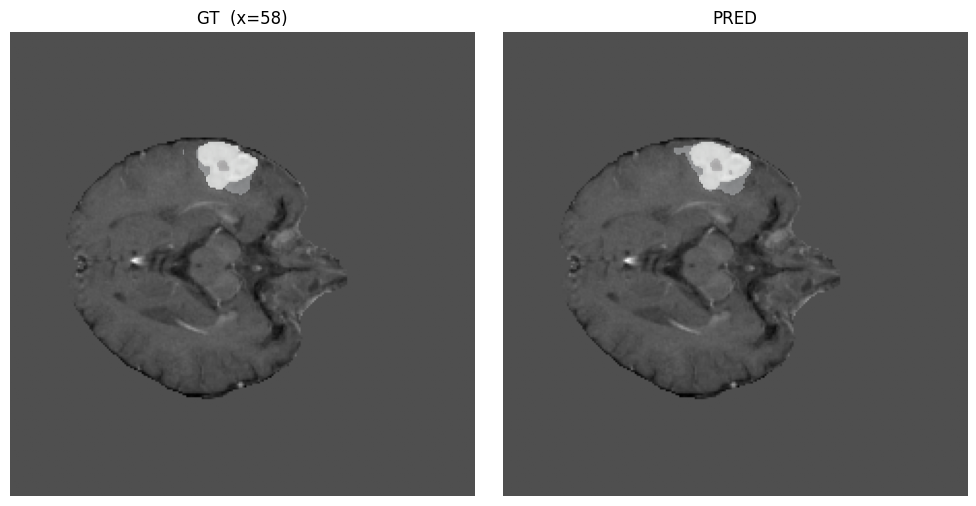

In [15]:
# ─────────────────────────────────────────────────────────────
# Load best model → run inference → compare GT vs PRED (TC/WT/ET)
# ─────────────────────────────────────────────────────────────
import os, torch, numpy as np, matplotlib.pyplot as plt

# 1) load best weights (same path you used when saving)
best_path = os.path.join(root_dir, "best_metric_model.pth")
assert os.path.exists(best_path), f"Missing {best_path}"
state = torch.load(best_path, map_location=device)
global_model.load_state_dict(state)
global_model.eval()
print(f"Loaded best weights from: {best_path}")

MOD_NAMES = ["FLAIR", "T1", "T1ce", "T2"]
LAB_IDX   = {"TC": 0, "WT": 1, "ET": 2}

@torch.no_grad()
def predict_case(sample, thresh=0.5):
    """
    sample: dict with "image" [4,D,H,W]
    returns: pred_bin [3,D,H,W] float {0,1}
    """
    x = sample["image"].unsqueeze(0).to(device)        # [1,4,D,H,W]
    logits = inference(x)                              # [1,3,D,H,W]
    probs  = torch.sigmoid(logits)[0]                  # [3,D,H,W]
    pred   = (probs > thresh).float().cpu()
    return pred

def dice_binary(pred, target, eps=1e-8):
    inter = (pred * target).sum().item()
    denom = pred.sum().item() + target.sum().item()
    return (2.0 * inter) / (denom + eps)

def per_class_dice(pred_bin, gt_bin):
    # pred_bin, gt_bin: [3,D,H,W] (floats 0/1)
    d_tc = dice_binary(pred_bin[0], gt_bin[0])
    d_wt = dice_binary(pred_bin[1], gt_bin[1])
    d_et = dice_binary(pred_bin[2], gt_bin[2])
    return d_tc, d_wt, d_et, (d_tc + d_wt + d_et)/3.0

def pick_sagittal_x(label_3dhw: torch.Tensor, target="ET") -> int:
    """
    Pick sagittal index x (along W) maximizing target area.
    target ∈ {"ET","WT","TC","TC-ET"}; "TC-ET" emphasizes NCR/NET-only.
    """
    tc = (label_3dhw[0] > 0.5)
    et = (label_3dhw[2] > 0.5)
    if target.upper() == "TC-ET":
        tgt = tc & ~et
        per_x = tgt.sum(dim=(0,1))  # [W]
    else:
        c = LAB_IDX[target.upper()]
        tgt = (label_3dhw[c] > 0.5)
        per_x = tgt.sum(dim=(0,1))
    x = int(torch.argmax(per_x).item()) if per_x.numel() else 0
    W = label_3dhw.shape[3]
    return max(0, min(x, W - 1))

def visualize_compare_sagittal(dataset, index=0, slice_target="ET", overlay_mod="T1ce", alpha=0.35, save_dir=None):
    """
    Side-by-side overlays (GT vs PRED) on the same **sagittal** slice.
    Colors: red=TC, green=ET, blue=WT (so ET stands out distinctly from TC).
    """
    sample = dataset[index]
    img   = sample["image"]           # [4,D,H,W]
    gt    = sample["label"]           # [3,D,H,W] (TC,WT,ET)
    pred  = predict_case(sample)      # [3,D,H,W]

    # choose sagittal index
    x = pick_sagittal_x(gt, target=slice_target)
    m_idx = MOD_NAMES.index(overlay_mod)

    img_np  = img.cpu().numpy()
    gt_np   = (gt.cpu().numpy()   > 0.5).astype(np.uint8)
    pred_np = (pred.cpu().numpy() > 0.5).astype(np.uint8)

    bg = img_np[m_idx, :, :, x]              # [D,H] plane

    # slice masks (D×H) — GT
    tc_g, wt_g, et_g = gt_np[0, :, :, x], gt_np[1, :, :, x], gt_np[2, :, :, x]
    # slice masks — PRED
    tc_p, wt_p, et_p = pred_np[0, :, :, x], pred_np[1, :, :, x], pred_np[2, :, :, x]

    # per-class dice on full volume
    d_tc, d_wt, d_et, d_mean = per_class_dice(torch.from_numpy(pred_np), torch.from_numpy(gt_np))
    print(f"Case {index} | Dice — TC:{d_tc:.3f}  WT:{d_wt:.3f}  ET:{d_et:.3f}  mean:{d_mean:.3f} | sagittal x={x}")

    def overlay(ax, bg, tc, wt, et, title):
        ax.imshow(bg, cmap="gray")
        ax.imshow(np.ma.masked_where(tc==0, tc), cmap="Reds",   alpha=alpha)   # TC
        ax.imshow(np.ma.masked_where(et==0, et), cmap="Greens", alpha=alpha)   # ET
        ax.imshow(np.ma.masked_where(wt==0, wt), cmap="Blues",  alpha=alpha)   # WT
        ax.set_title(title); ax.axis("off")

    # plot
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    overlay(axs[0], bg, tc_g, wt_g, et_g, f"GT  (x={x})")
    overlay(axs[1], bg, tc_p, wt_p, et_p, "PRED")
    plt.tight_layout()

    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
        base = os.path.splitext(os.path.basename(str(sample['label'].meta.get('filename_or_obj', f'case_{index}'))))[0]
        out = os.path.join(save_dir, f"{base}_sag_compare_{overlay_mod}_x{x}.png")
        plt.savefig(out, dpi=150, bbox_inches="tight")
        print(f"Saved {out}")

    plt.show()

# ── Quick run: print Dice for a few and visualize one ─────────────────
# summarize first N cases
N = min(5, len(val_dataset))
scores = []
for i in range(N):
    gt = val_dataset[i]["label"]
    pred = predict_case(val_dataset[i])
    d_tc, d_wt, d_et, d_mean = per_class_dice(pred, gt)
    scores.append((i, d_tc, d_wt, d_et, d_mean))
print("\nPer-class Dice on first", N, "val cases:")
for (i, a,b,c,m) in scores:
    print(f"  idx {i:02d} ▸ TC {a:.3f} | WT {b:.3f} | ET {c:.3f} | mean {m:.3f}")

# visualize one case (try ET emphasis first; switch to 'TC-ET' to see NCR/NET)
visualize_compare_sagittal(val_dataset, index=0, slice_target="ET",    overlay_mod="T1ce", alpha=0.35, save_dir=None)
# visualize_compare_sagittal(val_dataset, index=0, slice_target="TC-ET", overlay_mod="T1ce", alpha=0.35, save_dir=None)

